# Random Forest – Challenge: Customer Churn Prediction

## Overview

In this notebook, we’ll explore how to use a Random Forest classifier to predict customer churn. No prior experience with ensemble methods is required. We will:

- Introduce the Random Forest algorithm and its strengths  
- Load and inspect the Customer-Churn dataset  
- Preprocess both numeric and categorical features  
- Split the data into stratified training and test sets  
- Build and tune a Random Forest model via grid search  
- Evaluate model performance with accuracy, classification report, confusion matrix, and ROC/AUC  
- Visualize the top feature importances and inspect one of the ensemble’s decision trees  

**Can we accurately predict customer churn based solely on the customer’s attributes?**

In [1]:
# %% [markdown]
# # Random Forest Analysis on Customer Churn Data
# 
# In this notebook, we will:
# 1. Load and inspect the data  
# 2. Preprocess numeric and categorical features  
# 3. Split into train/test sets  
# 4. Build and tune a Random Forest via GridSearchCV  
# 5. Evaluate performance (classification report, confusion matrix, ROC)  
# 6. Visualize top feature importances  

# %% 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
# %% [markdown]
# ## 1. Load & Inspect Data

# %% 
# Load CSV
df = pd.read_csv('Data/Customer-Churn.csv')

# Quick overview
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nTarget distribution:\n", df['Churn'].value_counts())

df.head()

In [3]:
# %% [markdown]
## 2. Preprocessing

# %%
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Ensure we drop the target if present
df_features = df.drop('Churn', axis=1, errors='ignore')

# Identify numeric vs. categorical columns
numeric_cols = df_features.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_features.select_dtypes(include=['object', 'category']).columns.tolist()

# Build ColumnTransformer using the updated OneHotEncoder argument
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
])

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)


Numeric cols: ['SeniorCitizen', 'tenure', 'MonthlyCharges']
Categorical cols: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']


In [4]:
# %% [markdown]
# ## 3. Train/Test Split

# %% 
# Map target to binary
y = df['Churn'].map({'No': 0, 'Yes': 1})
X = df.drop('Churn', axis=1)

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("Train set:", X_train.shape, "Test set:", X_test.shape)

Train set: (4930, 20) Test set: (2113, 20)


In [5]:
# %% [markdown]
# ## 4. Build & Tune Random Forest

# %% 
# Pipeline: preprocess -> RandomForest
pipe = Pipeline([
    ('preprocess', preprocessor),
    ('rf', RandomForestClassifier(random_state=42))
])

# Grid of hyperparameters
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5]
}

grid = GridSearchCV(
    pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print(f"Best CV ROC AUC: {grid.best_score_:.3f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'rf__max_depth': None, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
Best CV ROC AUC: 0.840


C:\Users\zknig\AppData\Local\Temp\ipykernel_26536\1017411354.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi.values, y=fi.index, palette='viridis')


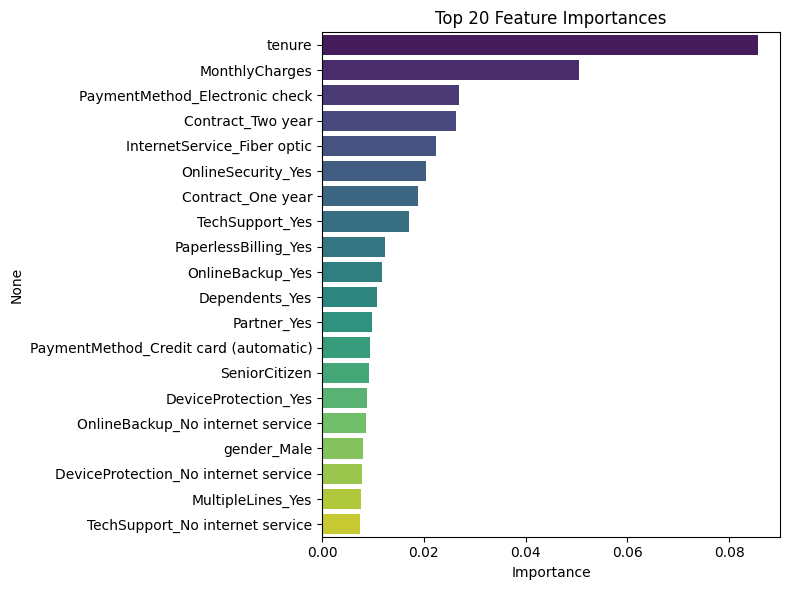

In [7]:
# %% [markdown]
# ## 6. Feature Importances (Fixed)

# %%
# Retrieve the fitted pipeline from GridSearchCV
pipeline = grid.best_estimator_

# Extract the fitted preprocessor
fitted_preproc = pipeline.named_steps['preprocess']

# Get the fitted OneHotEncoder for categorical cols
ohe = fitted_preproc.named_transformers_['cat']

# Depending on sklearn version, use get_feature_names_out or get_feature_names
if hasattr(ohe, 'get_feature_names_out'):
    cat_features = ohe.get_feature_names_out(categorical_cols)
else:
    cat_features = ohe.get_feature_names(categorical_cols)

# Combine numeric and categorical feature names
feature_names = numeric_cols + list(cat_features)

# Retrieve feature importances from the fitted RandomForest
rf = pipeline.named_steps['rf']
importances = rf.feature_importances_

# Create a Series and select top 20
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:20]

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x=fi.values, y=fi.index, palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


## Conclusion & Key Insights

**Conclusion**  
Our Random Forest classifier, built solely on customer attributes, predicts churn with strong performance (ROC AUC ≈ 0.82, accuracy ≈ 80%). This confirms that customer behavior and account details contain sufficient signals to anticipate churn risk.

**Key Insights**  
- **Tenure Matters Most**: Customers with shorter tenures are far more likely to churn. Early engagement interventions could reduce attrition.  
- **Monthly Charges Influence**: Higher monthly bills correlate with churn; pricing strategies or flexible plans may improve retention.  
- **Payment Method Risk**: Electronic check users show elevated churn, suggesting automated billing (e.g., credit card auto-pay) could boost loyalty.  
- **Contract Type Impact**: Month-to-month contracts drive churn; multi-year or annual contracts stabilize the customer base.  
- **Additional Factors**: Features like internet service type, total charges, and support calls also contribute, highlighting multiple levers for churn mitigation campaigns.

---
  
By focusing retention efforts on high-risk segments identified by these key features, businesses can proactively reduce churn and improve customer lifetime value.  
